In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [1]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200

name = 'realdata' #"simdata"
dj.config['schema_name'] = f"konstantin_nnsysident_{name}"

In [2]:
import torch
import shutil
import numpy as np
import pickle 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import matplotlib.pyplot as plt
import re
import seaborn as sns
import hiplot as hip
import statsmodels

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder
from nnfabrik.utility.hypersearch import Bayesian
from nnsysident.utility.measures import get_correlations

from nnsysident.tables.experiments import *
from nnsysident.tables.bayesian import *
from nnsysident.datasets.mouse_loaders import static_shared_loaders
from nnsysident.datasets.mouse_loaders import static_loaders
from nnsysident.tables.scoring import OracleScore, OracleScoreTransfer

from nnsysident.datasets.mouse_loaders import static_loader

def find_number(text, c):
    number_list = re.findall(r'%s(\d+)' % c, text)
    if len(number_list) == 0:
        number = None
    elif len(number_list) == 1:
        number = int(number_list[0])
    else:
        raise ValueError('More than one number found..') 
    return number


def get_transfer(transfer_hashes):
    # prepare the Transfer table in a way that all the info about the transferred model is in the DataFrame. Just pd.merge (on transfer_fn and transfer_hash)
    # it then with the model that the transferred model was used for. 
    
    transfer = pd.DataFrame((Transfer & 'transfer_hash in {}'.format(tuple(transfer_hashes))).fetch())
    transfer = pd.concat([transfer, transfer['transfer_config'].apply(pd.Series)], axis = 1).drop('transfer_config', axis = 1)

    restriction = transfer.rename(columns = {'t_model_hash': 'model_hash', 't_dataset_hash': 'dataset_hash', 't_trainer_hash': 'trainer_hash'})            
    restriction = restriction[['model_hash', 'dataset_hash', 'trainer_hash']].to_dict('records')

    tm = pd.DataFrame((TrainedModel * Dataset * Seed & restriction).fetch()).rename(
        columns = {'model_hash': 't_model_hash', 'trainer_hash': 't_trainer_hash', 'dataset_hash': 't_dataset_hash'})               
    tm = tm.sort_values('score', ascending=False).drop_duplicates(['t_model_hash', 't_trainer_hash', 't_dataset_hash'])

    transfer = pd.merge(transfer, tm, how='inner', on=['t_model_hash', 't_trainer_hash', 't_dataset_hash'])
    transfer = pd.concat([transfer, transfer['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
    transfer.columns = ['t_' + col if col[:2] != 't_' and col[:8] != 'transfer'  else col for col in transfer.columns]
    transfer = transfer.sort_values(['t_multi_match_n', 't_image_n', 't_multi_match_base_seed', 't_image_base_seed'])
    return transfer


def get_transfer_entries(old_experiment_name, overall_best):
    tm = pd.DataFrame((TrainedModel * Dataset * Seed * Experiments.Restrictions & 'experiment_name="{}"'.format(old_experiment_name)).fetch())
    tm = pd.concat([tm, tm['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)

    model_fn = np.unique(tm['model_fn'])
    assert len(model_fn) == 1 ,"Must have exactly 1 model function in experiment"
    model_fn = model_fn[0] 

    # Filter out best model(s) 
    if overall_best is True:
        tm = tm.loc[(tm['multi_match_n'] == tm['multi_match_n'].max()) & (tm['image_n'] == tm['image_n'].max())]
    tm = tm.sort_values('score', ascending=False).drop_duplicates(['multi_match_n', 'image_n', 'multi_match_base_seed', 'image_base_seed']).sort_values(['multi_match_n', 'image_n'])

    # make entries for Trasfer table
    entries = [dict(transfer_fn='nnsysident.models.transfer_functions.core_transfer', 
                     transfer_config = dict(t_model_hash=row.model_hash, t_dataset_hash=row.dataset_hash, t_trainer_hash=row.trainer_hash),
                     transfer_comment=model_fn.split('.')[-1] + ', multi_match_n={}, multi_match_base_seed={}, image_n={}, image_base_seed={}'.format(row.multi_match_n, 
                                                                                                                                    row.multi_match_base_seed, 
                                                                                                                                    row.image_n, 
                                                                                                                                    row.image_base_seed),
                     transfer_fabrikant='kklurz') for loc, row in tm.iterrows()]
    return entries

Connecting konstantin@sinzlab.chlkmukhxp6i.eu-central-1.rds.amazonaws.com:3306
Schema name: konstantin_nnsysident_realdata


In [ ]:
PreprocessedMouseData() #& 'animal_id in (22564, 22846, 23343,23555, 23656)'

In [ ]:
(TrainedModel * Dataset * Experiments.Restrictions & 'experiment_name = "Real, Direct, se2d_fullgaussian2d, 11-set"').fetch('dataset_config', limit=1, as_dict=True)

In [ ]:
ExperimentsTransfer()

In [23]:
# core-transfer (best)
data = pd.DataFrame()
for experiment_name in ["Real, core_transfer (best), se2d_fullgaussian2d, 4-set -> 4-set", 
                        "Real, core_transfer (best from GAUSSIAN!), se2d_spatialxfeaturelinear, 4-set -> 4-set"]:
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer_hashes = list(data_.transfer_hash)
    transfer_ = get_transfer(transfer_hashes)
    data_ = pd.merge(data_, transfer_, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})

In [28]:
model_fn = "nnsysident.models.models.se2d_spatialxfeaturelinear"
corrs = []
for image_n in np.unique(data['# images']):
    my_data = data.loc[(data['# images'] == image_n) & (data['multi_match_base_seed'] == 1) & (data['model_fn'] == model_fn)]
    key = dict(model_hash=my_data.model_hash.values[0],
               dataset_hash=my_data.dataset_hash.values[0], 
               trainer_hash = my_data.trainer_hash.values[0],
               transfer_hash = my_data.transfer_hash.values[0])
    key = (TrainedModelTransfer & key).proj().fetch1()
    dataloaders, model = TrainedModelTransfer().load_model(key=key)  
    test_correlation = get_correlations(model, dataloaders["test"], device='cuda', as_dict=False, per_neuron=True)
    corrs.append(test_correlation)
    
corrs2 = corrs.copy()

data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already

In [ ]:
# bad neurons
idx = ((corrs1[-1] > 0.5) & (corrs2[-1] < 0.3) )
idx = np.where(idx)[0]
print(idx)
for i,_ in enumerate(idx):
    print(corrs1[0][idx[i]])
    print(corrs2[0][idx[i]])
    print(corrs1[-1][idx[i]])
    print(corrs2[-1][idx[i]])
    print("-----------------------------")

In [ ]:
bad_neuron_idx = [3275, 3521]

In [ ]:
# good neurons
idx = ((corrs1[0] > 0.1) & (corrs2[0] < 0.05) & (corrs1[-1] < 0.4) & (corrs2[-1] < 0.4) & (corrs1[-1] > 0.3) & (corrs2[-1] > 0.3))
idx = np.where(idx)[0]
print(idx)
for i,_ in enumerate(idx):
    print(corrs1[0][idx[i]])
    print(corrs2[0][idx[i]])
    print(corrs1[-1][idx[i]])
    print(corrs2[-1][idx[i]])
    print("-----------------------------")

In [24]:
model_fn = "nnsysident.models.models.se2d_spatialxfeaturelinear"

all_weights = []
for n_images in np.unique(data['# images']):
    my_data = data.loc[(data['# images'] == n_images) & (data['multi_match_base_seed'] == 1) & (data['model_fn'] == model_fn)]
    key = dict(model_hash=my_data.model_hash.values[0],
               dataset_hash=my_data.dataset_hash.values[0], 
               trainer_hash = my_data.trainer_hash.values[0],
              transfer_hash = my_data.transfer_hash.values[0])
    key = (TrainedModelTransfer & key).proj().fetch1()
    dataloaders, model = TrainedModelTransfer().load_model(key=key) 
    weights = model.readout['22564-3-12-0'].normalized_spatial
    all_weights.append(weights)

data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already

In [25]:
model_fn = "nnsysident.models.models.se2d_fullgaussian2d"
mus = []
sigmas = []
for n_images in np.unique(data['# images']):
    my_data = data.loc[(data['# images'] == n_images) & (data['multi_match_base_seed'] == 1) & (data['model_fn'] == model_fn)]
    key = dict(model_hash=my_data.model_hash.values[0],
               dataset_hash=my_data.dataset_hash.values[0], 
               trainer_hash = my_data.trainer_hash.values[0],
              transfer_hash = my_data.transfer_hash.values[0])
    key = (TrainedModelTransfer & key).proj().fetch1()
    dataloaders, model = TrainedModelTransfer().load_model(key=key) 
    mus.append(model.readout['22564-3-12-0'].mu[0].detach().numpy())
    sigmas.append(model.readout['22564-3-12-0'].sigma[0].detach().numpy())

data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


/src/nnsysident/nnsysident/models/models.py:139: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



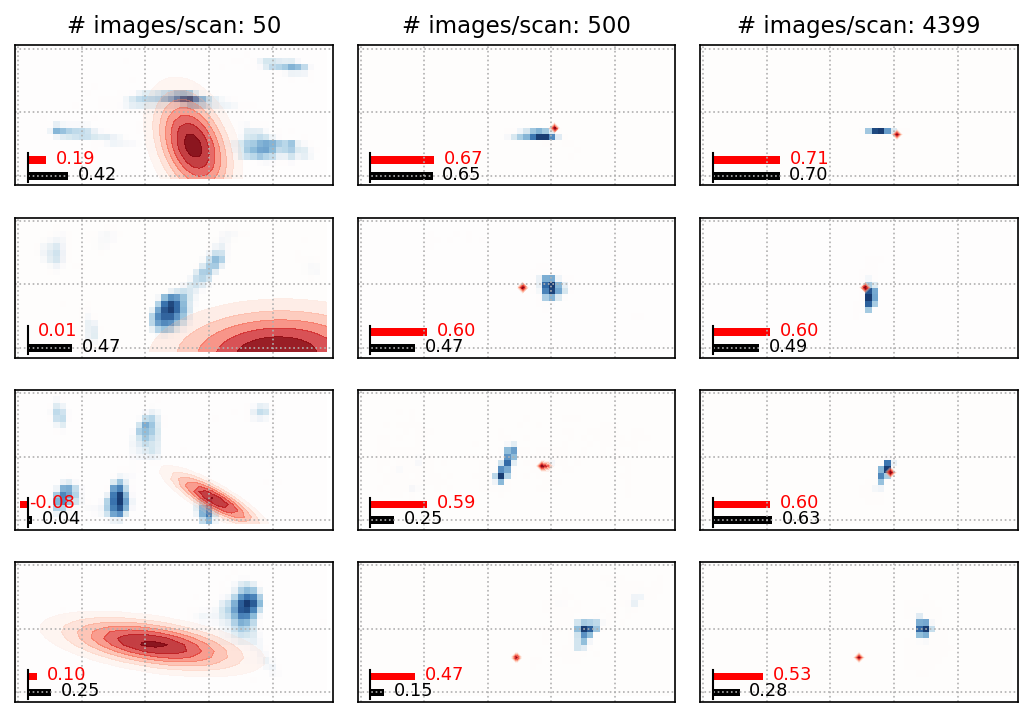

In [29]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
3511, 3105, 3036,3460

final_indices_raw = np.array([3511, 3105, 3036, 3751])
final_indices = final_indices_raw - (985 + 979 + 978)



def transform_spatial_scale(x_init, init_range, final_range):
    return (x_init - min(init_range)) * (max(final_range - min(final_range)) / max(init_range - min(init_range))) + min(final_range)

def new_cmap(cmap):
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
    my_cmap = ListedColormap(my_cmap)
    return my_cmap

init_range_w = [-1, 1]
final_range_w = [0, 22]

init_range_h = [-1, 1]
final_range_h = [0, 50]

cmap_contourf = new_cmap(plt.get_cmap("Reds"))
cmap_imshow = new_cmap(plt.get_cmap("Blues"))

fig, axes = plt.subplots(len(final_indices), 3, figsize=(7, 5), dpi=150)

image_ns = [200, 2000, 17596]
#image_ns = [4000, 10000, 17596]
i = 0

for final_idx in final_indices:
    
    for image_set_ind in np.where(np.isin(np.unique(data['# images']), np.array(image_ns)))[0]:
            
        ax = axes.flat[i]
        i += 1

        weights = all_weights[image_set_ind][final_idx].detach().numpy()
        A = sigmas[image_set_ind][final_idx]
        mean = mus[image_set_ind][final_idx].squeeze()
        gaussian_perf = corrs1[image_set_ind][final_indices_raw[np.where(final_indices == final_idx)[0]]][0]
        featurex_perf = corrs2[image_set_ind][final_indices_raw[np.where(final_indices == final_idx)[0]]][0]
        
        mean = np.array([mean[1], mean[0]])
        #A = np.array([[A[1,1], A[1,0]], [A[0,1], A[0,0]]])
        A = A[:,::-1]
        covariance_mat = np.dot(A, A.T)

        scale_h = np.abs(np.diff(final_range_h)[0]) / np.abs(np.diff(init_range_h)[0])
        scale_w = np.abs(np.diff(final_range_w)[0]) / np.abs(np.diff(init_range_w)[0])

        # define the range for x(height) and y(width)
        x, y = np.mgrid[-1:1:.04, -1:1:.09090909090909091]
        pos = np.dstack((x, y))

        x_new, y_new = np.mgrid[-.5:49.5:1, -.5:21.5:1]
        rv = multivariate_normal(mean, covariance_mat)

        # plot them  
        ax.contourf(x_new, y_new, rv.pdf(pos), cmap=cmap_contourf)
        #ax.plot(mean[0],mean[1], marker="x", markersize=7, color="red")
        ax.imshow(weights, cmap=cmap_imshow)
        
        if i < 4:
            ax.set_title('# images/scan: ' + str(int(np.unique(data['# images'])[image_set_ind]/4)), fontsize=11)
        
        ax.set(xticklabels=[], yticklabels=[])
        ax.xaxis.set_ticks_position('none'); ax.yaxis.set_ticks_position('none')
    
        ax.barh([20, 17.5], [featurex_perf * 15, gaussian_perf * 15], height=1.2, left=1.5, color=['k', 'r'])
        ax.plot([1.5, 1.5], [21, 16.5], lw=1, c='k')
        ax.text(featurex_perf * 15 + 3, 19.8, '{:.2f}'.format(featurex_perf), va='center', fontsize=8.5, color='k')
        ax.text(gaussian_perf * 15 + 3, 17.3, '{:.2f}'.format(gaussian_perf), va='center', fontsize=8.5, color='r')
        ax.grid(True, linestyle=":")
           
fig.tight_layout()    
# fig.savefig('readoutpositions - 4 neurons.pdf', dpi=150)

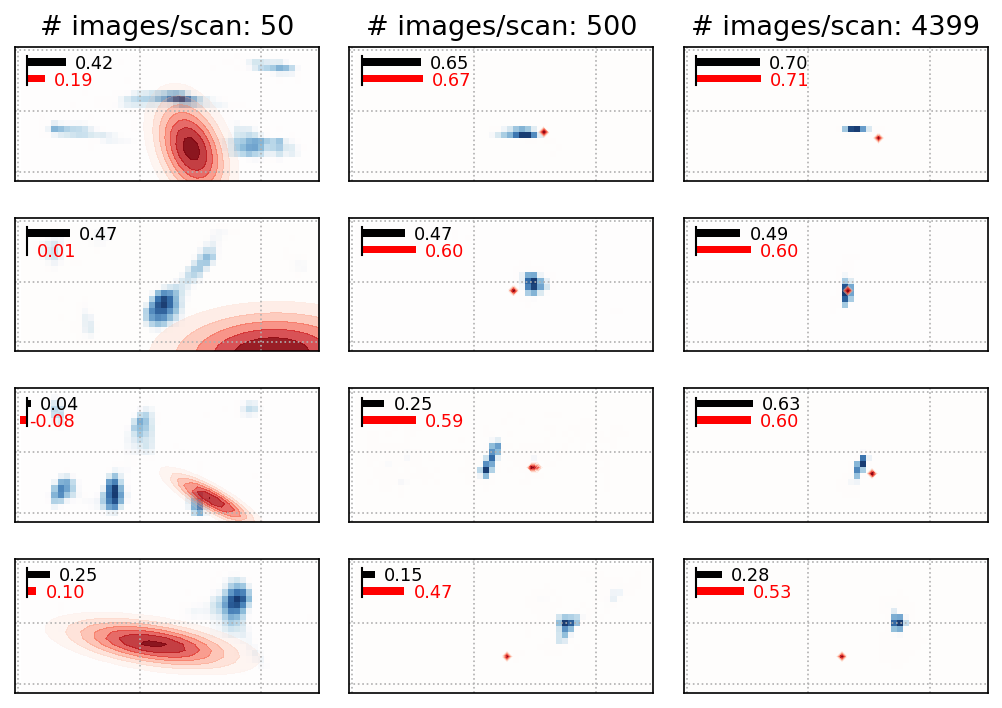

In [70]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
3511, 3105, 3036,3460

final_indices_raw = np.array([3511, 3105, 3036, 3751])
final_indices = final_indices_raw - (985 + 979 + 978)



def transform_spatial_scale(x_init, init_range, final_range):
    return (x_init - min(init_range)) * (max(final_range - min(final_range)) / max(init_range - min(init_range))) + min(final_range)

def new_cmap(cmap):
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
    my_cmap = ListedColormap(my_cmap)
    return my_cmap

init_range_w = [-1, 1]
final_range_w = [0, 22]

init_range_h = [-1, 1]
final_range_h = [0, 50]

cmap_contourf = new_cmap(plt.get_cmap("Reds"))
cmap_imshow = new_cmap(plt.get_cmap("Blues"))

fig, axes = plt.subplots(len(final_indices), 3, figsize=(7, 5), dpi=150)

image_ns = [200, 2000, 17596]
#image_ns = [4000, 10000, 17596]
i = 0

for final_idx in final_indices:
    
    for image_set_ind in np.where(np.isin(np.unique(data['# images']), np.array(image_ns)))[0]:
            
        ax = axes.flat[i]
        i += 1

        weights = all_weights[image_set_ind][final_idx].detach().numpy()
        A = sigmas[image_set_ind][final_idx]
        mean = mus[image_set_ind][final_idx].squeeze()
        gaussian_perf = corrs1[image_set_ind][final_indices_raw[np.where(final_indices == final_idx)[0]]][0]
        featurex_perf = corrs2[image_set_ind][final_indices_raw[np.where(final_indices == final_idx)[0]]][0]
        
        mean = np.array([mean[1], mean[0]])
        #A = np.array([[A[1,1], A[1,0]], [A[0,1], A[0,0]]])
        A = A[:,::-1]
        covariance_mat = np.dot(A, A.T)

        scale_h = np.abs(np.diff(final_range_h)[0]) / np.abs(np.diff(init_range_h)[0])
        scale_w = np.abs(np.diff(final_range_w)[0]) / np.abs(np.diff(init_range_w)[0])

        # define the range for x(height) and y(width)
        x, y = np.mgrid[-1:1:.04, -1:1:.09090909090909091]
        pos = np.dstack((x, y))

        x_new, y_new = np.mgrid[.5:50.5:1, .5:22.5:1]
        rv = multivariate_normal(mean, covariance_mat)

        # plot them  
        ax.contourf(x_new, y_new, rv.pdf(pos), cmap=cmap_contourf)
        #ax.plot(mean[0],mean[1], marker="x", markersize=7, color="red")
        ax.imshow(weights, cmap=cmap_imshow)
        
        if i < 4:
            ax.set_title('# images/scan: ' + str(int(np.unique(data['# images'])[image_set_ind]/4)), fontsize=13)
        
        ax.set(xticklabels=[], yticklabels=[])
        ax.xaxis.set_ticks_position('none'); ax.yaxis.set_ticks_position('none')
    
        ax.barh([2, 4.7], [featurex_perf * 15, gaussian_perf * 15], height=1.2, left=1.5, color=['k', 'r'])
        ax.plot([1.5, 1.5], [1, 5.7], lw=1, c='k')
        ax.text(featurex_perf * 15 + 3, 2.2, '{:.2f}'.format(featurex_perf), va='center', fontsize=8.5, color='k')
        ax.text(gaussian_perf * 15 + 3, 5, '{:.2f}'.format(gaussian_perf), va='center', fontsize=8.5, color='r')
        ax.grid(True, linestyle=":")
           
fig.tight_layout()
fig.subplots_adjust(wspace=.1, hspace=.01)
fig.savefig('readoutpositions - 4 neurons.pdf', dpi=150)

In [ ]:
final_indices

In [38]:
22 - 17.3

4.699999999999999

In [ ]:
model_fn = "nnsysident.models.models.se2d_fullgaussian2d"

models, loaders = {}, {}
for model_fn in ["nnsysident.models.models.se2d_fullgaussian2d", "nnsysident.models.models.se2d_spatialxfeaturelinear"]:
    n_images = 17596
    my_data = data.loc[(data['# images'] == n_images) & (data['multi_match_base_seed'] == 1) & (data['model_fn'] == model_fn)]
    key = dict(model_hash=my_data.model_hash.values[0],
               dataset_hash=my_data.dataset_hash.values[0], 
               trainer_hash = my_data.trainer_hash.values[0],
              transfer_hash = my_data.transfer_hash.values[0])
    key = (TrainedModelTransfer & key).proj().fetch1()
    dataloaders, model = TrainedModelTransfer().load_model(key=key) 
    models[model_fn] = model
    loaders[model_fn] = loaders

In [ ]:
gRFs = {}
X = torch.FloatTensor(1, 1, 36, 64).fill_(100) # check again
for key, model in models.items():
    gRFs[key] = []
    for neuron in final_indices:
        model = model.cuda()
        x = X.cuda()
        x.requires_grad=True
        y =model(x, '22564-3-12-0')
    
        y[0, neuron].backward()
        gRF = x.grad.cpu().detach().numpy()
        gRFs[key].append(gRF)

In [ ]:
fig, axes = plt.subplots(len(final_indices), 2, figsize=(7, 10), dpi=150)
for i, (readout, values) in enumerate(gRFs.items()):
    for j, n in enumerate(values):
        ax = axes[j][i]
        ax.imshow(n.squeeze(), cmap='gray')
        ax.set(xticklabels=[], yticklabels=[])
        ax.xaxis.set_ticks_position('none'); ax.yaxis.set_ticks_position('none')
        if j == 0:
            ax.set_title(readout.split('.')[-1][5:])
fig.savefig('rfs.pdf', dpi=150)

---

### Changes by MB

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

def transform_spatial_scale(x_init, init_range, final_range):
    return (x_init - min(init_range)) * (max(final_range - min(final_range)) / max(init_range - min(init_range))) + min(final_range)

def new_cmap(cmap):
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
    my_cmap = ListedColormap(my_cmap)
    return my_cmap

init_range_w = [-1, 1]
final_range_w = [0, 22]

init_range_h = [-1, 1]
final_range_h = [0, 50]

cmap_contourf = new_cmap(plt.get_cmap("Reds"))
cmap_imshow = new_cmap(plt.get_cmap("Blues"))

fig, axes = plt.subplots(len(final_indices), 3, figsize=(7, 5), dpi=150)

image_ns = [200, 2000, 10000]
i = 0

for final_idx in final_indices:
    
    for image_set_ind in np.where(np.isin(np.unique(data['# images']), np.array(image_ns)))[0]:
            
        ax = axes.flat[i]
        i += 1

        weights = all_weights[image_set_ind][final_idx].detach().numpy()
        A = sigmas[image_set_ind][final_idx]
        mean = mus[image_set_ind][final_idx].squeeze()
        gaussian_perf = corrs1[image_set_ind][final_indices_raw[np.where(final_indices == final_idx)[0]]][0]
        featurex_perf = corrs2[image_set_ind][final_indices_raw[np.where(final_indices == final_idx)[0]]][0]
        
        mean = np.array([mean[1], -mean[0]])
        A = np.array([[A[1,1], A[1,0]], [-A[0,1], -A[0,0]]])
        #mean = np.array([-mean[1]])


        covariance_mat = np.dot(A, A.T)
        mean = transform_spatial_scale(mean[0], np.array(init_range_h), np.array(final_range_h)), transform_spatial_scale(mean[1], np.array(init_range_w), np.array(final_range_w))

        scale_h = np.abs(np.diff(final_range_h)[0]) / np.abs(np.diff(init_range_h)[0])
        scale_w = np.abs(np.diff(final_range_w)[0]) / np.abs(np.diff(init_range_w)[0])

        D=np.diag([scale_h, scale_w])
        covariance_mat = D @ A @ A.T @ D
        #covariance_mat = np.dot(covariance_mat, [[scale_h**2, 0], [0, scale_w**2]])


        # define the range for x(height) and y(width)
        x, y = np.mgrid[-.5:50:.01, -.5:22:.01]
        pos = np.dstack((x, y))

        rv = multivariate_normal(mean, covariance_mat)

        # plot them  
        ax.contourf(x, y, rv.pdf(pos), cmap=cmap_contourf)
        ax.plot(mean[0],mean[1], marker="x", markersize=7, color="red")
        ax.imshow(weights, origin='bottom', cmap=cmap_imshow)
        
        if i < 4:
            ax.set_title('# images: ' + str(np.unique(data['# images'])[image_set_ind]))
        
        ax.set(xticklabels=[], yticklabels=[])
        ax.xaxis.set_ticks_position('none'); ax.yaxis.set_ticks_position('none')
        
#         [x_0, x_1], [y_0, y_1] = np.array(ax.get_position())
#         ax_inner = fig.add_axes([x_0+.02, y_0+.02, .1, .5])
#         ax.bar([1.5, 3], [15, 10], bottom=3)
    
        ax.barh([20, 17.5], [featurex_perf * 15, gaussian_perf * 15], height=1.2, left=1.5, color=['k', 'r'])
        ax.plot([1.5, 1.5], [21, 16.5], lw=1, c='k')
        ax.text(featurex_perf * 15 + 3, 19.8, '{:.2f}'.format(featurex_perf), va='center', fontsize=6.5, color='k')
        ax.text(gaussian_perf * 15 + 3, 17.3, '{:.2f}'.format(gaussian_perf), va='center', fontsize=6.5, color='r')
        
#         break;
#     break;
        
fig.tight_layout()    
#fig.savefig('readoutpositions - 4 neurons.pdf', dpi=150)

---

In [ ]:
sns.palplot(palette)

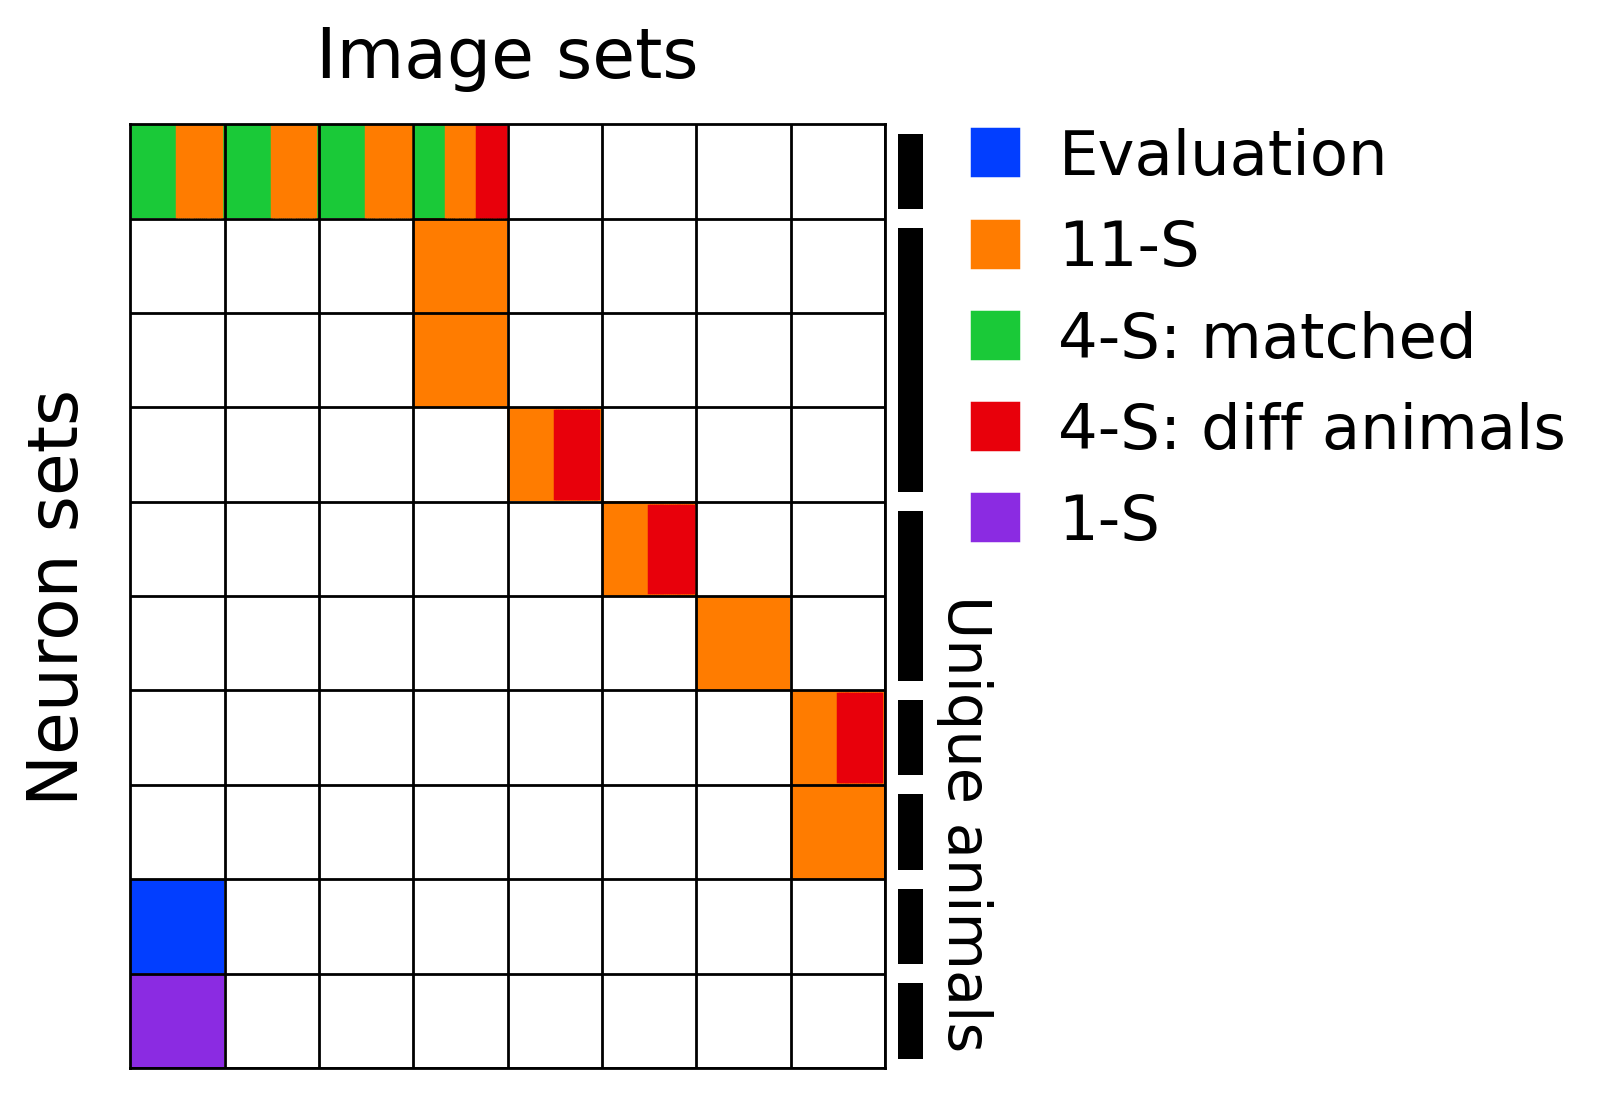

In [22]:
import matplotlib as mpl
datasets = np.zeros((10, 8))
datasets[0, :4] = 1
datasets[-2, 0] = 2
datasets[-1, 0] = 3
datasets[np.arange(1, 8), [3, 3, 4, 5, 6, 7, 7]] = 4

palette = sns.color_palette('bright')[:2] + sns.color_palette('bright')[1:5]
colors = ['None', palette[3], palette[0], palette[-1], palette[1]]

bounds = [0, 1, 2, 3, 4]
cmap = mpl.colors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(5, 5), dpi=250)
ax.imshow(datasets, cmap=cmap) #, aspect=1.05);
ax.set(xticks=np.arange(datasets.shape[1]) + .5, yticks=np.arange(datasets.shape[0]) + .5, xticklabels=[], yticklabels=[])
ax.xaxis.set_ticks_position('none'); ax.yaxis.set_ticks_position('none')
ax.grid(c='k')
# text
image_text = ax.text(3.5, -1, "Image sets", fontsize=20, ha='center')
neuron_text = ax.set_ylabel("Neuron sets", fontsize=20);

# legend
from matplotlib.lines import Line2D
labels = ["4-S: matched", "Evaluation", "1-S", "11-S", "4-S: diff animals"]
cs = colors[1:] + [palette[-2]]
order = [1, 3, 0, 4, 2]
legend_elements = [Line2D([], [], marker="s", markersize=13, linewidth=0, color=cs[o], label=labels[o]) for o in order]
lgd = ax.legend(handles=legend_elements, loc=(1.03, .52), edgecolor="None", fontsize=18, handletextpad=0.01);

# make the shaded part 
yloc = 0
for xloc in [0, 1, 2]:
    xlocs = np.arange(xloc, xloc+.48, .02)
    for ind, xloc in enumerate(xlocs):
        alpha=1#ind/len(xlocs)
        ax.plot([xloc, xloc], [yloc-.5, yloc+.47], lw=1., c=colors[-1], alpha=alpha)

xlocs = np.arange(2.847, 3.16, .02)
for ind, xloc in enumerate(xlocs):
    alpha = 1
    ax.plot([xloc, xloc], [yloc-.5, yloc+.47], lw=1., c=colors[-1], alpha=alpha)       

xlocs = np.arange(3.17, 3.48, .02)
for ind, xloc in enumerate(xlocs):
    alpha = 1
    ax.plot([xloc, xloc], [yloc-.5, yloc+.47], lw=1., c=palette[-2], alpha=alpha)

xloc, yloc = 4, 3
xlocs = np.arange(xloc, xloc+.47, .02)
for ind, xloc in enumerate(xlocs):
    alpha = 1
    ax.plot([xloc, xloc], [yloc-.46, yloc+.46], lw=1., c=palette[-2], alpha=alpha)

xloc, yloc = 5, 4
xlocs = np.arange(xloc, xloc+.461, .02)
for ind, xloc in enumerate(xlocs):
    alpha = 1
    ax.plot([xloc, xloc], [yloc-.46, yloc+.46], lw=1., c=palette[-2], alpha=alpha)  

xloc, yloc = 7, 6
xlocs = np.arange(xloc, xloc+.465, .02)
for ind, xloc in enumerate(xlocs):
    alpha = 1
    ax.plot([xloc, xloc], [yloc-.46, yloc+.46], lw=1., c=palette[-2], alpha=alpha)   
# add the lines
ax_animal = fig.add_axes([.825, .125, .02, .755])
ax_animal.set_ylim(0, datasets.shape[0] * .1)
import matplotlib.patches as patches
animal_id0 = patches.Rectangle((0, 0.11), 1., .08, linewidth=1, facecolor='k')
animal_id1 = patches.Rectangle((0, 0.01), 1., .08, linewidth=1, facecolor='k')
animal_id2 = patches.Rectangle((0, 0.91), 1., .08, linewidth=1, facecolor='k')
animal_id3 = patches.Rectangle((0, .61), 1., .28, linewidth=1, facecolor='k')
animal_id4 = patches.Rectangle((0, .41), 1., .18, linewidth=1, facecolor='k')
animal_id5 = patches.Rectangle((0, .31), 1., .08, linewidth=1, facecolor='k')
animal_id6 = patches.Rectangle((0, .21), 1., .08, linewidth=1, facecolor='k')

# Add the patch to the Axes
ax_animal.add_patch(animal_id0)
ax_animal.add_patch(animal_id1)
ax_animal.add_patch(animal_id2)
ax_animal.add_patch(animal_id3)
ax_animal.add_patch(animal_id4)
ax_animal.add_patch(animal_id5)
ax_animal.add_patch(animal_id6)

ax_animal.axis('off')
ax.text(8.04, 9.2, "Unique animals", fontsize=17, rotation=-90) #, va='center', ha='center')
fig.savefig('datasets.pdf', bbox_inches='tight')

In [ ]:
(3.48 - 2.53) / 3

In [ ]:
2.53 + .317 * 2